# The MilkyWay, its halo, tides and orbits
This notebook deals mostly with Section 3 of the paper. 
It shows 
* the Milky Way model
* the stability of integrated orbits
* their $\chi_*$ distributions
* the effects of smooth-tides

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../adiabatic-tides")
sys.path.append("..")

import adiabatic_tides as at
import cusp_encounters.milkyway
import cusp_encounters.encounters_math as em

cachedir = "../caches"

G = 43.0071057317063e-10 # Mpc (km/s)^2 / Msol 

In [2]:
mw = cusp_encounters.milkyway.MilkyWay(adiabatic_contraction=True, cachedir=cachedir)

# Enclosed Mass profile

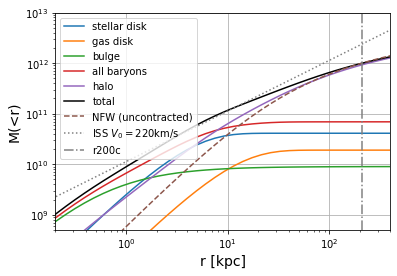

In [3]:
iss = at.profiles.IsothermalSphere(rho0=9.0e11, r0=1.)

ri = np.logspace(-4,0.5) * 200e-3

#plt.loglog(ri*1e3, mw.profile_nfw.m_of_r(ri))
#plt.loglog(ri*1e3, mw.enclosed_mass(ri*1e6, components="hsgb"), linestyle="dashed")
plt.loglog(ri*1e3, mw.enclosed_mass(ri*1e6, components="s"), label="stellar disk")
plt.loglog(ri*1e3, mw.enclosed_mass(ri*1e6, components="g"), label="gas disk")
plt.loglog(ri*1e3, mw.enclosed_mass(ri*1e6, components="b"), label="bulge")
plt.loglog(ri*1e3, mw.enclosed_mass(ri*1e6, components="sbg"), label="all baryons")
plt.loglog(ri*1e3, mw.enclosed_mass(ri*1e6, components="h"), label="halo")
plt.loglog(ri*1e3, mw.enclosed_mass(ri*1e6, components="hsbg"), label="total", color="black")

plt.loglog(ri*1e3, mw.profile_nfw.self_m_of_r(ri), label="NFW (uncontracted)", linestyle="dashed")

#plt.loglog(ri*1e3, mw.enclosed_mass(ri*1e6, components="h"), linestyle="dashed")
plt.loglog(ri*1e3, iss.m_of_r(ri), label=r"ISS $V_0=%d$km/s"%iss.v0, color="grey", linestyle="dotted")

plt.axvline(mw.profile_nfw.r200c*1e3, ls="-.", color="grey", label="r200c")

plt.xlim(2e-1,4e2)
plt.ylim(5e8,1e13)
plt.xlabel("r [kpc]", fontsize=14)
plt.ylabel("M(<r)", fontsize=14)
plt.grid()
plt.legend(fontsize=10, loc="upper left")

plt.savefig("img/mw_profiles.pdf", bbox_inches="tight")

# Orbits
## Check that the profile is stable

Note that after adding the baryons the DM profile may not be 100% in equilibrium. 

However, it seems that the Eddington inversion (using the full potential of the spherically averaged mass distribution) takes care of this very well.

Note that we had to use a large number of time-steps to achieve stability in the central region $\lesssim 1$kpc

In [4]:
%%time
orbits = mw.create_dm_orbits(100000, nsteps=100000, rmax=500e3, addinfo=True, adaptive=True, subsamp=100)

reading
CPU times: user 2.92 s, sys: 12.3 s, total: 15.2 s
Wall time: 16 s


(0.0, 2.0)

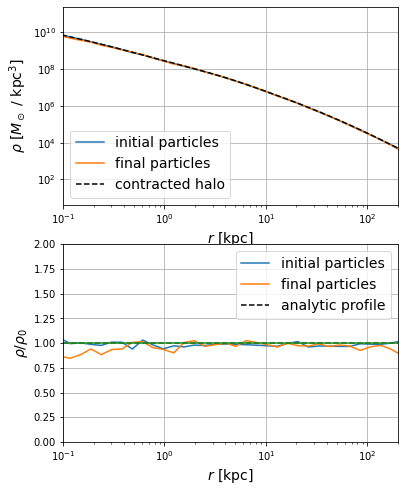

In [5]:
ri, rho_ini = em.calculate_density_profile(orbits["pos"][0]/1000., m=orbits["mass"])
#ri, rho_ini = em.calculate_density_profile(pos*1000., m=mass)
ri, rho_fin = em.calculate_density_profile(orbits["pos"][-1]/1000., m=orbits["mass"])
rho_ref = mw.profile_halo.self_density(ri*1e-3)*1e-9

fig, axs = plt.subplots(2,1, figsize=(6,8))

axs[0].loglog(ri, rho_ini, label="initial particles")
axs[0].loglog(ri, rho_fin, label="final particles")
axs[0].loglog(ri, rho_ref, linestyle="dashed", color="black", label="contracted halo")

axs[1].semilogx(ri, rho_ini / rho_ref, label="initial particles")
axs[1].semilogx(ri, rho_fin / rho_ref, label="final particles")
axs[1].axhline(1., color="black", linestyle="dashed", label="analytic profile")

axs[0].set_ylabel(r"$\rho$ [$M_\odot$ / kpc$^3$]", fontsize=14)
axs[1].set_ylabel(r"$\rho / \rho_0$", fontsize=14)

axs[1].plot(ri, mw.profile_halo.self_density(ri*1e-3)/mw.profile_halo.self_density(ri*1e-3))

for ax in axs:
    ax.set_xlabel(r"$r$ [kpc]", fontsize=14)
    ax.legend(fontsize=14)
    ax.set_xlim(1e-1, 2e2)
    ax.grid("on")
    
axs[1].set_ylim(0,2)

# Column Density Distribution

Note: for estimating the distributions we assign the final values of columndensities and $\chi$ and assign them at 1000 different points of the orbit. This is fine, since the profile is equilibrium and we could have equally likely encountered each cusp at any point of its orbit

We are not using the column density distribution for anything, but it is still interesting to see it. E.g. if we were directly interested in the distribution of impact parameters (and not the distribution of shock parameters) and additionally the stellar distribution were perfectly at rest, then this would be the relevant quantity.

Typical cusps in the central 10kpc have gone through column densities of $10^4 M_\odot / \rm{pc}^2$.

In [6]:
r = np.linalg.norm(orbits["pos"][::1], axis=-1)
cdens = orbits["scolumndens"][-1] * np.ones_like(orbits["scolumndens"][::1])
chi = orbits["chi_star"][-1] * np.ones_like(orbits["chi_star"][::1])
chi_dm = orbits["chi_dm"][-1] * np.ones_like(orbits["chi_dm"][::1])

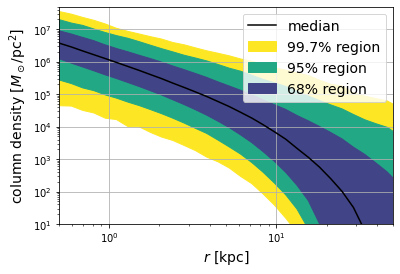

In [7]:
rbins = np.logspace(-1,np.log10(200.), 50)
ri, perc = em.get_percentile_profile(r/1000., cdens, xbins=rbins, weights=orbits["mass"]*np.ones(r.shape))

em.percentile_plot(ri, perc, ylabel=r"column density [$M_\odot / \rm{pc}^2$]")
plt.ylim(1e1, 5e7)
plt.xlim(None,50.)
plt.savefig("img/radial_column_density.pdf", bbox_inches="tight")

# $\chi_*$ distribution

The relevant parameter to infer the shock strength distribution is the time integral of the stellar mass density over a cusps orbit
$$
\chi_* = \int \rho_*(\vec{x}(t)) dt
$$
We plot this parameter here and the related characteristic shock $B_* = 2\pi G \chi_*$

In [8]:
ri, perc = em.get_percentile_profile(r/1000., chi, xbins=rbins, weights=orbits["mass"]*np.ones(r.shape))
ri, perc2 = em.get_percentile_profile(r/1000., chi+chi_dm*0.04, xbins=rbins, weights=orbits["mass"]*np.ones(r.shape))

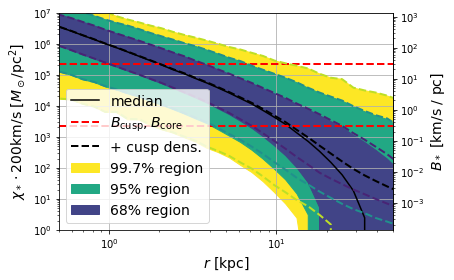

In [9]:
em.percentile_plot(ri, perc*200., ylabel=r"$\chi_* \cdot 200 \rm{km/s}$ [$M_\odot / \rm{pc}^2$]")

def chi200kms_to_Bstar(chi200kms):
    return chi200kms / 200. * mw.G * 2.*np.pi
def Bstar_to_chi200kms(chiG):
    return chiG * 200. / (mw.G * 2.*np.pi)

ax_chiG = plt.gca().secondary_yaxis('right', functions=(chi200kms_to_Bstar, Bstar_to_chi200kms))
ax_chiG.set_ylabel("$B_*$ [km/s / pc]", fontsize=14)

plt.axhline(Bstar_to_chi200kms(0.3), ls="--", label=r"$B_{\rm{cusp}}, B_{\rm{core}}$", color="red", lw=2)
plt.axhline(Bstar_to_chi200kms(30.), ls="--", color="red", lw=2)

plt.ylim(1e0,1e7)
plt.xlim(None,50.)

plt.legend(loc="lower left", fontsize=14)
plt.savefig("img/radial_chi_profile.pdf", bbox_inches="tight")

for i in (0,1,2,4,5,6):
    icol = min(i, 6-i)
    vi =[0.,0.4,0.8]
    plt.plot(ri, perc2[:,i]*200., linestyle="dashed", color=plt.get_cmap("viridis_r")(vi[icol]+0.1),lw=2)
plt.plot(ri, perc2[:,3]*200., linestyle="dashed", color="black",lw=2, label="+ cusp dens.")
plt.legend(loc="lower left", fontsize=14)

plt.savefig("img/radial_chi_plus_cusp_profile.pdf", bbox_inches="tight")

# $\chi_{\rm{cusp}}$ distribution

In [10]:
ri, perc = em.get_percentile_profile(r/1000., chi_dm*0.04, xbins=rbins, weights=orbits["mass"]*np.ones(r.shape))

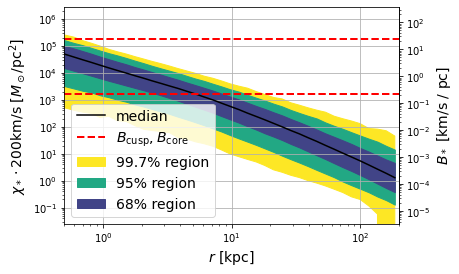

In [11]:
em.percentile_plot(ri, perc*200., ylabel=r"$\chi_* \cdot 200 \rm{km/s}$ [$M_\odot / \rm{pc}^2$]")

def chi200kms_to_Bstar(chi200kms):
    return chi200kms / 200. * mw.G * 2.*np.pi
def Bstar_to_chi200kms(chiG):
    return chiG * 200. / (mw.G * 2.*np.pi)

ax_chiG = plt.gca().secondary_yaxis('right', functions=(chi200kms_to_Bstar, Bstar_to_chi200kms))
ax_chiG.set_ylabel("$B_*$ [km/s / pc]", fontsize=14)

plt.axhline(Bstar_to_chi200kms(0.224), ls="--", label=r"$B_{\rm{cusp}}, B_{\rm{core}}$", color="red", lw=2)
plt.axhline(Bstar_to_chi200kms(23.7), ls="--", color="red", lw=2)

#plt.ylim(1e0,1e6)
#plt.xlim(None,50.)

plt.legend(loc="lower left", fontsize=14)
plt.savefig("img/radial_chi_cusps_profile.pdf", bbox_inches="tight")

# Peri-center distribution (relevant for smooth tides)

Typical cusps have a peri-center two times smaller than the radius we observe them

In [12]:
%%time
r = np.linalg.norm(orbits["pos"], axis=-1)
rperi = np.min(r, axis=0)
ri, perc = em.get_percentile_profile(r/1000., (rperi/(r)), weights=orbits["mass"]*np.ones(r.shape))

CPU times: user 1min 6s, sys: 15.9 s, total: 1min 22s
Wall time: 1min 22s


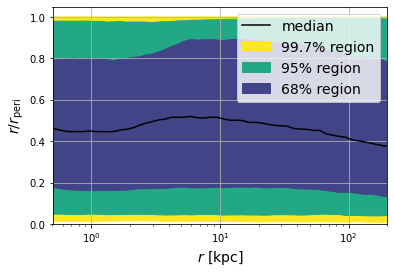

In [13]:
em.percentile_plot(ri, perc, ylabel=r"$r / r_{\rm{peri}}$")

plt.yscale("linear")
plt.ylim(0.,1.05)

plt.savefig("img/radial_r_to_rperi_ratio.pdf", bbox_inches="tight")

## The tidal field of the Milky Way

Here we use the spherically averaged mass profile and the radial eigenvalue of its tidal tensor. We need this to later evaluate the effect of smooth tides. $\lambda_{\rm{200c}}$ is defined as explained in [Stücker et al. (2022)](https://arxiv.org/abs/2207.00604)

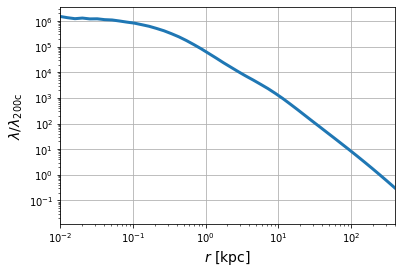

In [14]:
ri = np.logspace(-2,3)
l200c = 100.*(100.*0.68/1e6)**2 #100 H0**2, H0 in km/s/pc
plt.loglog(ri, mw.radial_mean_tide(ri*1e3, components="hsbg")/l200c, label="total", lw=3)
plt.grid()
plt.ylabel(r"$\lambda / \lambda_{\rm{200c}}$", fontsize=14)
plt.xlabel(r"$r$ [kpc]", fontsize=14)
plt.xlim(1e-2,4e2)
plt.savefig("img/milky_way_mean_tide.pdf", bbox_inches="tight")

# Compare the effect of smooth tides and encounters in one plot

The smooth tide effect is inferred from the tidal field at peri-center. As explained in the paper, we can define an effective shock parameter to describe the joint effect of tides+encounters

In [15]:
Bstar = 2.*np.pi*chi*mw.G

Bcusps = 2.*np.pi*chi_dm*0.04*mw.G

Bhist = em.sample_effective_B_hist(r.shape, Bminfac=1e-4, p=1.2, initial_sample=100000, cachefile="%s/Beff_hist.hdf5" % cachedir)
Beff_star = Bhist * Bstar
Beff_cusps = Bhist * Bcusps #  Irealized later that this is a dramatic overestimate

Beff_tide = np.sqrt(42.2*mw.radial_mean_tide(rperi))*np.ones(r.shape)
Beff_tot= np.sqrt(Beff_star**2 + Beff_tide**2)

<ipython-input-15-8cd2b68c2900>:9: RuntimeWarning: invalid value encountered in sqrt
  Beff_tide = np.sqrt(42.2*mw.radial_mean_tide(rperi))*np.ones(r.shape)


In [16]:
%%time
rbins = np.logspace(-1,np.log10(200.), 50)
ri, perc_Bstar = em.get_percentile_profile(r/1000., Bstar, xbins=rbins, weights=orbits["mass"]*np.ones(r.shape))
ri, perc_Bcusps = em.get_percentile_profile(r/1000., Bcusps, xbins=rbins, weights=orbits["mass"]*np.ones(r.shape))
ri, perc_Btide = em.get_percentile_profile(r/1000., Beff_tide, xbins=rbins, weights=orbits["mass"]*np.ones(r.shape))

ri, perc_Beff_star = em.get_percentile_profile(r/1000., Beff_star, xbins=rbins, weights=orbits["mass"]*np.ones(r.shape))
ri, perc_Beff_cusps = em.get_percentile_profile(r/1000., Beff_cusps, xbins=rbins, weights=orbits["mass"]*np.ones(r.shape))
ri, perc_Btot = em.get_percentile_profile(r/1000., Beff_tot, xbins=rbins, weights=orbits["mass"]*np.ones(r.shape))

CPU times: user 4min 39s, sys: 55.1 s, total: 5min 34s
Wall time: 5min 35s


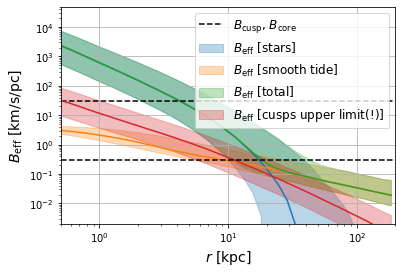

In [17]:
ax = plt.gca()

def plot_perc(perc, color=None, label=None):
    ax.loglog(ri, perc[:,3], color=color)
    ax.fill_between(ri, perc[:,2], perc[:,-3], label=label, color=color, alpha=0.3)
    
#plot_perc(perc_Bstar, label=r"$B_*$", color="C0")
#plot_perc(perc_Bcusps, label=r"$B_{\rm{cusps}}$", color="C1")
plot_perc(perc_Beff_star, label=r"$B_{\rm{eff}}$ [stars]", color="C0")
#plot_perc(perc_Benc, label=r"$B_{\rm{eff, enc.}}$", color="C4")
plot_perc(perc_Btide, label=r"$B_{\rm{eff}}$ [smooth tide]", color="C1")
plot_perc(perc_Btot, label=r"$B_{\rm{eff}}$ [total]", color="C2")

ax.axhline(0.3, linestyle="dashed", color="black", label=r"$B_{\rm{cusp}}$, $B_{\rm{core}}$", zorder=5)
ax.axhline(30., linestyle="dashed", color="black")

ax.set_ylabel(r"$B_{\rm{eff}}$ [km/s/pc]", fontsize=14)
ax.set_xlabel(r"$r$ [kpc]", fontsize=14)
ax.set_xlim(5e-1,2e2)
ax.set_ylim(2e-3,5e4)
ax.grid("on")
ax.legend(fontsize=12, loc="upper right")

plt.savefig("img/Beff_all_effects.pdf", bbox_inches="tight")

# We make an upper limit estimate of the effect of cusp-cusp encounters
# For these we make a generous upper limit estimate of their integrated mass
# density, by assuming 4% of all dark matter mass is in cusps. Then
# we assume that we can also treat them in the distant-tide limit and the point
# mass limit. However, the second point is actually not true at all!
# Therefore, the cusp encounter effect modelled here is a dramatic overestimate, since actual
# shocks of cusps are limited to B << 1e-4 km/s/pc, because of the finite
# extend of the perturber and the approximations made to estimate the
# shock distribution do not hold. Even so, the effect seems to be irrelevant
# when the smooth tidal field is considered:
plot_perc(perc_Beff_cusps, label=r"$B_{\rm{eff}}$ [cusps upper limit(!)]", color="C3")
ax.legend(fontsize=12, loc="upper right")
plt.savefig("img/Beff_all_effects_plus_cusps.pdf", bbox_inches="tight")


# Here a comparison between two different implementations of the halo contraction
I decided using the (empirical) [Cautun et al. (2020)](https://arxiv.org/abs/1911.04557) contraction instead of the analyic [Sellwood & McGaugh (2005)](https://arxiv.org/abs/astro-ph/0507589) model, since it turned out to match the galactic centre excess better, and since it has been better empirically verified

In [18]:
def halo_angle_histogram(mw=None, m0=1e12, c0=9.4):
    if mw is None:
        mw = cusp_encounters.milkyway.MilkyWay(adiabatic_contraction=True, cachedir=cachedir, mass_halo=m0, conc_initial=c0)

    rhalo = np.logspace(-2, 4, 100000)
    rcent = np.sqrt(rhalo[1:]*rhalo[:-1])
    Jshalo = (mw.profile_contracted_nfw.self_density(rcent*1e-3)*1e-18)**2 *4.*np.pi/3. * ((1e3*rhalo[1:])**3 - (1e3*rhalo[:-1])**3)
    
    print("%.2e" % mw.profile_contracted_nfw.m_of_r(0.2105))
    return em.angle_histogram(rcent*1e3, Jshalo, nalpha=400, d=8200., logalphamin=-2.5)

mw1 = cusp_encounters.milkyway.MilkyWay(adiabatic_contraction=True, cachedir=cachedir,
                                       mode="sellwood_mcgaugh_2005")
mw2 = cusp_encounters.milkyway.MilkyWay(adiabatic_contraction=True, cachedir=cachedir,
                                       mode="cautun_2020")

Reading result of previous calculation from ../caches/contracted_nfw.hdf5 (i=20)


1.11e+12
9.95e+11


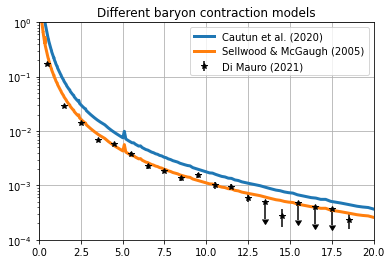

In [19]:
nfac = 1.444e-05 # This is the normalization factor used by Delos & White (2022)
ax1 = plt.gca()

plt.title("Different baryon contraction models")
for mw,label in (mw1, "Cautun et al. (2020)"), (mw2, "Sellwood & McGaugh (2005)"):
    alpha, Jtothalo = halo_angle_histogram(mw=mw)
    ax1.loglog(alpha*180/np.pi, Jtothalo*nfac,  lw=3, label=label)

data = np.loadtxt("../data/di_mauro_fig10.txt")
di_mauro_angle, di_mauro_sb, di_mauro_error, di_mauro_ulim = data.T

ax1.errorbar(di_mauro_angle[di_mauro_sb > 1e-18], di_mauro_sb[di_mauro_sb > 1e-18], di_mauro_error[di_mauro_sb > 1e-18], 
             color="black", ls="none",  marker="*", label="Di Mauro (2021)")
ax1.errorbar(di_mauro_angle[di_mauro_ulim>1e-18], di_mauro_ulim[di_mauro_ulim>1e-18], yerr=0.5*di_mauro_ulim[di_mauro_ulim>1e-18], 
             uplims=True, color="black", ls="none", marker="*")
plt.xscale("linear")
plt.xlim(0,20)
plt.ylim(1e-4, 1e0)
plt.grid()
plt.legend()